In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
"""
Access image arrays with im_dict['image_name']    
Access match array with match_dict['match_name']
"""

# load all images, normalize them
im_dir = os.path.join(os.getcwd(), "MP4_part2_data")
im_names = ["gaudi1", "gaudi2", "house1", "house2", "lab1", "lab2", "library1", "library2"]
im_paths = [os.path.join(im_dir, im_name + ".jpg") for im_name in im_names]
im_array = [Image.open(im_path) for im_path in im_paths]

pair_dict = dict()
pair_dict["gaudi"]   = (im_array[0], im_array[1])
pair_dict["house"]   = (im_array[2], im_array[3])
pair_dict["lab"]     = (im_array[4], im_array[5])
pair_dict["library"] = (im_array[6], im_array[7])
    
# load all match files
match_names = ["lab", "library"]
match_paths = [os.path.join(im_dir, match_name + "_matches.txt") for match_name in match_names]
match_arrays = [np.loadtxt(match_path) for match_path in match_paths]
match_dict = dict()
for i in range(len(match_names)):
    match_dict[match_names[i]] = match_arrays[i]
    
# load other files
lab3d = np.loadtxt(os.path.join(im_dir, "lab_3d.txt"))
lib1_cam = np.loadtxt(os.path.join(im_dir, "library1_camera.txt"))
lib2_cam = np.loadtxt(os.path.join(im_dir, "library2_camera.txt"))
text_dict = dict()
text_dict["lab"] = lab3d
text_dict["library"] = (lib1_cam, lib2_cam)

In [3]:
# this is a N x 4 file where the first two numbers of each row
# are coordinates of corners in the first image and the last two
# are coordinates of corresponding corners in the second image: 
# matches(i,0:2) is a point in the first image
# matches(i,2:4) is a corresponding point in the second image
def fit_fundamental(matches, normalize=True, debug=False):
    n_rows, n_cols = matches.shape
    U = np.empty((n_rows,9)) 
    
    matches_copy = np.copy(matches)
    centered_matches = np.empty((matches.shape))
    norm_matches = np.empty((matches.shape))
    
    # if normalizing, center and normalize both sets of points
    if(normalize):
        mean_x_im_1 = np.mean(matches[:,0])
        mean_y_im_1 = np.mean(matches[:,1])
        mean_x_im_2 = np.mean(matches[:,2])
        mean_y_im_2 = np.mean(matches[:,3])
        centered_matches[:,0] = matches[:,0] - mean_x_im_1
        centered_matches[:,1] = matches[:,1] - mean_y_im_1
        centered_matches[:,2] = matches[:,2] - mean_x_im_2
        centered_matches[:,3] = matches[:,3] - mean_y_im_2
        # calculate distances from each point to origin
        norms_im_1 = np.linalg.norm(centered_matches[:,0:2], axis=1)
        norms_im_2 = np.linalg.norm(centered_matches[:,2:4], axis=1)
        # calculate mean squared distance between points in both images to origin
        ms_distance_im_1 = np.mean(norms_im_1)
        ms_distance_im_2 = np.mean(norms_im_2)
        # create scaling matrices T and T' (shape 2x2)
        scaling_factor = 2**0.5
        s_fact_1 = scaling_factor / ms_distance_im_1
        s_fact_2 = scaling_factor / ms_distance_im_2
        T2 = np.diag([s_fact_1, s_fact_1])
        Tp2 = np.diag([s_fact_2, s_fact_2])
        # scale points in both images
        matches_1 = T2@centered_matches[:,0:2].T
        matches_2 = Tp2@centered_matches[:,2:4].T
        matches = np.vstack((matches_1, matches_2)).T
        
        if(debug):
            # for sanity, check that our matches array is now scaled as we expected
            norms_im_1 = np.linalg.norm(matches[:,0:2], axis=1)
            norms_im_2 = np.linalg.norm(matches[:,2:4], axis=1)
            # calculate mean squared distance between points in both images to origin
            ms_distance_im_1 = np.mean(norms_im_1)
            ms_distance_im_2 = np.mean(norms_im_2)
            print("Mean distance after normalization: " + str((ms_distance_im_1, ms_distance_im_2)))
    
    # construct U
    for i in range(n_rows):
        row = matches[i]
        x = row[0]
        y = row[1]
        xp = row[2]
        yp = row[3]
        U[i] = [xp*x, xp*y, xp, yp*x, yp*y, yp, x, y, 1]
    
    # do svd on U.T * U
    utu = np.matmul(U.T, U)
    u, s, v = np.linalg.svd(utu)
    
    # take v[-1] to get eigenvector with smallest value
    F_init = v[-1].reshape((3,3))
    
    # do svd again and throw out smallest eigenvalue
    u, s, v = np.linalg.svd(F_init)
    s[2] = 0 # throw out smallest value
    s = np.diag(s)
    # reconstruct F
    F = u@s@v
    
    # if normalizing, transform F back into original coordinates
    if(normalize):
        T3 = np.array([[s_fact_1, 0,        -s_fact_1 * mean_x_im_1],
                       [0,        s_fact_1, -s_fact_1 * mean_y_im_1],
                       [0,        0,        1]])
        Tp3 = np.array([[s_fact_2, 0,       -s_fact_2 * mean_x_im_2],
                       [0,        s_fact_2, -s_fact_2 * mean_y_im_2],
                       [0,        0,        1]])
        F = Tp3.T@F@T3
    
    return F

## Fundamental matrix estimation from ground truth matches. 
Load the lab and library image pairs and matching points file using the starter code. Add your own code to fit a fundamental matrix to the matching points and use the sample code to visualize the results. You need to implement and compare the normalized and the unnormalized algorithms (see this lecture for the methods). For each algorithm and each image pair, report your residual, or the mean squared distance in pixels between points in both images and the corresponding epipolar lines.

In [4]:
plot_xcoords = dict()
plot_xcoords["lab"] = [0, 4000]
plot_xcoords["library"] = [0, 3000]

NORMALIZATION = True

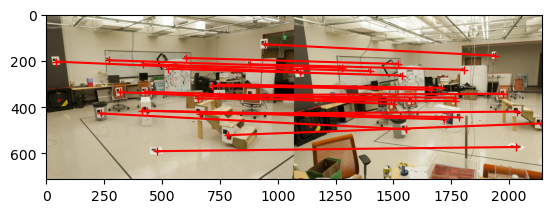

Residuals for lab: 0.6177545048999434 with normalization = True


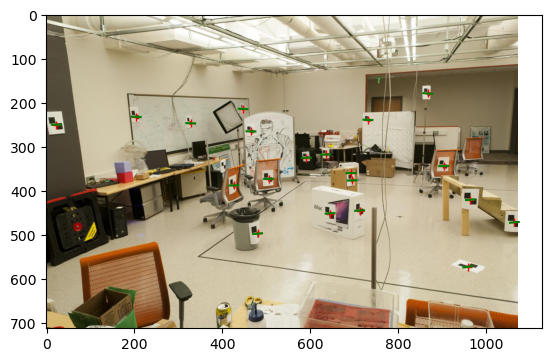

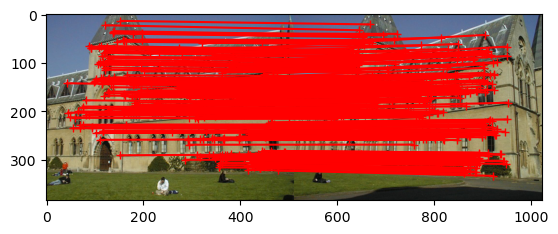

Residuals for library: 0.1835817005817689 with normalization = True


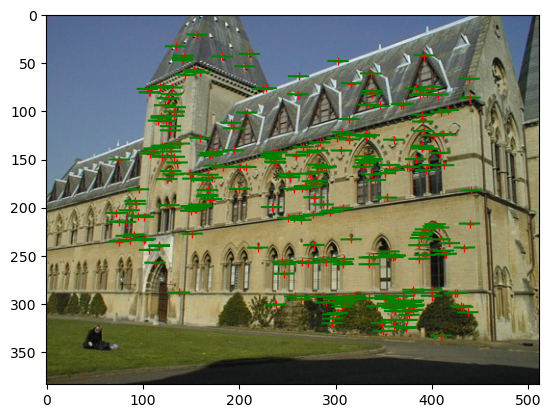

In [5]:
for loc in ["lab", "library"]:

    I1, I2 = pair_dict[loc]
    matches = match_dict[loc]

    # this is a N x 4 file where the first two numbers of each row
    # are coordinates of corners in the first image and the last two
    # are coordinates of corresponding corners in the second image: 
    # matches(i,1:2) is a point in the first image
    # matches(i,3:4) is a corresponding point in the second image

    N = len(matches)

    ##
    ## display two images side-by-side with matches
    ## this code is to help you visualize the matches, you don't need
    ## to use it to produce the results for the assignment
    ##

    I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
    I3[:,:I1.size[0],:] = I1;
    I3[:,I1.size[0]:,:] = I2;

    im1 = np.array(I1).astype('float') / 255
    im2 = np.array(I2).astype('float') / 255
    im3 = np.array(I3).astype('float') / 255

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(im3)
    ax.plot(matches[:,0],matches[:,1],  '+r')
    ax.plot(matches[:,2]+I1.size[0],matches[:,3], '+r')
    ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
    plt.show()

    ##
    ## display second image with epipolar lines reprojected 
    ## from the first image
    ##

    # first, fit fundamental matrix to the matches
    F = fit_fundamental(matches, NORMALIZATION);    
    
    M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
    L1 = np.matmul(F, M).transpose() # transform points from 
    # the first image to get epipolar lines in the second image

    # find points on epipolar lines L closest to matches(:,2:4)
    l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
    L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
    pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
    closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())
    
    # calculate residuals
    residuals = np.mean(np.abs(pt_line_dist))
    print("Residuals for " + loc + ": " + str(residuals) + " with normalization = " + str(NORMALIZATION))

    # find endpoints of segment on epipolar line (for display purposes)
    pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10  # offset from the closest point is 10 pixels
    pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

    # display points and segments of corresponding epipolar lines
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(im2)
    ax.plot(matches[:,2],matches[:,3],  '+r')
    ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')

    # display segments
    ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
    
    # save fig
    plt.savefig(loc + "_" + ("norm" if NORMALIZATION else "no_norm") + ".png")

#     # display whole lines
#     NUM_LINES = max(8, matches.shape[0] // 32)
#     # generate random indices
#     r_indices = np.random.choice(L1.shape[0], NUM_LINES, replace=False)  
#     A = L[:,0][r_indices]
#     B = L[:,1][r_indices]
#     C = L[:,2][r_indices]
#     slope = -A / B
#     intercept = -C / B
#     x1s = np.full(NUM_LINES, plot_xcoords[loc][0])
#     x2s = np.full(NUM_LINES, plot_xcoords[loc][1])
#     y1s = slope * x1s + intercept
#     y2s = slope * x2s + intercept
#     ax.plot([x1s, x2s], [y1s, y2s], 'g')

    plt.show()

## Camera calibration. 
For the lab pair, calculate the camera projection matrices by using 2D matches in both views and 3-D point coordinates given in lab_3d.txt in the data file. Refer to [this lecture](http://slazebni.cs.illinois.edu/fall22/lec15_calibration.pdf) for the calibration method. Once you have computed your projection matrices, you can evaluate them using the evaluate_points function included in the starter code, which will provide you the projected 2-D points and residual error. (Hint: For a quick check to make sure you are on the right track, empirically this residual error should be < 20 and the squared distance of your projected 2-D points from actual 2-D points should be < 4.)

In [6]:
## Camera Calibration
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

In [39]:
## Camera Centers
matches = match_dict['lab']
N = matches.shape[0]
coords_3d = np.hstack((lab3d, np.ones((N,1))))

A1 = np.empty((2*N, 12))
A2 = np.empty((2*N, 12))

for i in range(N):
    A1[2*i]   = np.hstack((np.zeros(4), coords_3d[i], -matches[i][1] * coords_3d[i]))
    A1[2*i+1] = np.hstack((coords_3d[i], np.zeros(4), -matches[i][0] * coords_3d[i]))
    A2[2*i]   = np.hstack((np.zeros(4), coords_3d[i], -matches[i][3] * coords_3d[i]))
    A2[2*i+1] = np.hstack((coords_3d[i], np.zeros(4), -matches[i][2] * coords_3d[i]))
    
u1, s1, v1 = np.linalg.svd(A1.T @ A1)
u2, s2, v2 = np.linalg.svd(A2.T @ A2)

P1 = v1[-1].reshape((3,4))
P2 = v2[-1].reshape((3,4))

projected_points_1, residual_1 = evaluate_points(P1, matches[:,0:2], lab_3d_coords)
projected_points_2, residual_2 = evaluate_points(P2, matches[:,2:4], lab_3d_coords)

print("P1: ")
print(P1)
print("P2: ")
print(P2)
print("Residual 1:")
print(residual_1)
print("Residual 2:")
print(residual_2)

P1: 
[[-3.09964003e-03 -1.46204621e-04  4.48498051e-04  9.78930705e-01]
 [-3.07018018e-04 -6.37193506e-04  2.77356192e-03  2.04144279e-01]
 [-1.67933501e-06 -2.74767706e-06  6.83965442e-07  1.32882923e-03]]
P2: 
[[-6.93154938e-03  4.01684736e-03  1.32602741e-03  8.26700552e-01]
 [-1.54768772e-03 -1.02452740e-03  7.27440891e-03  5.62523259e-01]
 [-7.60946320e-06 -3.70953979e-06  1.90203021e-06  3.38807796e-03]]
Residual 1:
13.54575868652185
Residual 2:
15.544967510793688


Calculate the camera centers for the lab and library pairs using the estimated or provided projection matrices.

In [43]:
P1_lab = P1
P2_lab = P2
P1_library = lib1_cam
P2_library = lib2_cam

q, r = np.linalg.qr(P1)

[[-9.95130249e-01  9.85686297e-02 -1.17332354e-04]
 [-9.85672250e-02 -9.95121168e-01 -4.28519321e-03]
 [-5.39145531e-04 -4.25276026e-03  9.99990812e-01]]
[[ 3.11480837e-03  2.08300517e-04 -7.19696648e-04 -9.94286207e-01]
 [ 0.00000000e+00  6.19685242e-04 -2.71582525e-03 -1.06662087e-01]
 [ 0.00000000e+00  0.00000000e+00 -1.12539129e-05  3.39159095e-04]]


In [ ]:
## Triangulation